Training set contains 3184 images across 2 classes
Test set contains 200 images across 2 classes
Feature shape for training: (3184, 13056)
Feature shape for testing: (200, 13056)
Training XGBoost classifier...
Evaluating the model...
Test Accuracy: 0.8250
Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.82      0.82       100
           1       0.82      0.83      0.83       100

    accuracy                           0.82       200
   macro avg       0.83      0.82      0.82       200
weighted avg       0.83      0.82      0.82       200



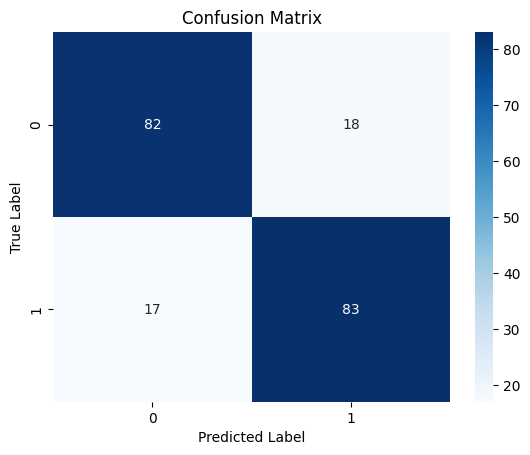

In [5]:
# Rolwyn Raju - 40303902
# Pretty Kotian - 40320837
# Praneet Avhad - 40279347

import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import xgboost as xgb
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns

IMAGE_DIMS = (64, 64) 
TRAIN_FILE = "train.txt"
TEST_FILE = "val.txt"

def preprocess_images(file_path):
    features_list = []
    labels_list = []
    class_mapping = {}
    class_index = 0

    with open(file_path, "r") as file:
        image_files = file.read().splitlines()

    for file_name in image_files:
        file_name = file_name.strip()
        if not os.path.exists(file_name):
            continue
        
        label_name = os.path.dirname(file_name).split(os.sep)[-1]
        if label_name not in class_mapping:
            class_mapping[label_name] = class_index
            class_index += 1
        
        image = cv2.imread(file_name)
        if image is None:
            continue
        
        image = cv2.resize(image, IMAGE_DIMS)
        pixel_data = image.flatten()
        
        histogram_features = []
        for channel in range(3):
            hist = cv2.calcHist([image], [channel], None, [256], [0, 256]).flatten()
            histogram_features.extend(hist)
        
        combined_features = np.hstack([pixel_data, histogram_features])
        features_list.append(combined_features)
        labels_list.append(class_mapping[label_name])
    
    return np.array(features_list), np.array(labels_list), class_mapping

X_train, y_train, train_classes = preprocess_images(TRAIN_FILE)
X_test, y_test, test_classes = preprocess_images(TEST_FILE)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"Training set contains {len(y_train)} images across {len(train_classes)} classes")
print(f"Test set contains {len(y_test)} images across {len(test_classes)} classes")
print(f"Feature shape for training: {X_train_scaled.shape}")
print(f"Feature shape for testing: {X_test_scaled.shape}")

pca_model = PCA(n_components=1000)
X_train_pca = pca_model.fit_transform(X_train_scaled)
X_test_pca = pca_model.transform(X_test_scaled)

xgb_model = xgb.XGBClassifier(
    n_estimators=50,
    max_depth=4,
    learning_rate=0.1,
    objective='multi:softmax',
    num_class=3,
    eval_metric='mlogloss',
    n_jobs=-1
)

print("Training XGBoost classifier...")
xgb_model.fit(X_train_pca, y_train)

# Testing the model
print("Evaluating the model...")
y_pred = xgb_model.predict(X_test_pca)
accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {accuracy:.4f}")
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, cmap="Blues", fmt="d")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()
